## Feature Engineering (Time) & Final Modeling

In [53]:
import os
import json
import pickle
import warnings
from utils import info, split_train_and_test_period, evaluation, split_x_and_y_log, parsing_output

import shap

from sklearn.preprocessing import LabelEncoder

from sacred import Experiment
from sacred.observers import FileStorageObserver

from xgboost import XGBRegressor


warnings.filterwarnings('ignore')
%config InlineBackend.figure_format = 'retina'

### 데이터 로드 & 전처리
- 1시간, 하루, 일주일 전의 과거 cnt 데이터 추가
- 일주일 전의 과거 cnt 데이터의 평균과 표준편차 데이터 추가

In [3]:
base_query = """
WITH base_data AS (
    # nyc_taxi 테이블의 좌표가 gis에 있는 geo값이 포함되어 있는 row만 출력하여 zip_code 정보를 얻어내는 테이블 : 12322300rows
    SELECT nyc_taxi.*, gis.* EXCEPT (zip_code_geom)
    FROM (
        SELECT *
        FROM `bigquery-public-data.new_york_taxi_trips.tlc_yellow_trips_2015`
        WHERE 
            EXTRACT(MONTH from pickup_datetime) = 1
            and pickup_latitude BETWEEN -90 AND 90
        ) AS nyc_taxi
    JOIN (
        SELECT zip_code, state_code, state_name, city, county, zip_code_geom
        FROM `bigquery-public-data.geo_us_boundaries.zip_codes`
        WHERE state_code='NY'
        ) AS gis 
    ON ST_CONTAINS(zip_code_geom, st_geogpoint(pickup_longitude, pickup_latitude))
)
, distinct_datetime AS (
    # base_data 에서 hour 이후 값을 제거하고 유니크한 시간단위의 pickup data의 정보를 얻어내는 테이블 : 744rows
    # Datetime만 distinct해서 가져옴(비어있지 않을것이라 가정)
    SELECT distinct DATETIME_TRUNC(pickup_datetime, hour) as pickup_hour
    FROM base_data
)
, distinct_zip_code AS (
    # base_data 에서 zip_code의 정보를 얻어내는 테이블 : 374
    # zip_code만 distinct해서 가져옴(이외의 zip_code는 나오지 않을것이라 가정)
    SELECT distinct zip_code
    FROM base_data
)
, zip_code_datetime_join AS (
    # zip_code, pickup_hour의 정보를 가진 두 테이블을 join하여 여러 단위의 날짜 데이터를 얻는 테이블 : 278256rows
    SELECT
        *,
        EXTRACT(MONTH FROM pickup_hour) AS month,
        EXTRACT(DAY FROM pickup_hour) AS day,
        CAST(FORMAT_DATETIME('%u', pickup_hour) AS INT64) -1 AS weekday,
        EXTRACT(HOUR FROM pickup_hour) AS hour,
        CASE WHEN CAST(FORMAT_DATETIME('%u', pickup_hour) AS INT64) IN (6, 7) THEN 1 ELSE 0 END AS is_weekend
    FROM distinct_zip_code  
    CROSS JOIN distinct_datetime
)
, agg_data AS (
    # base_data 에서 zip_code별 시간 단위의 픽업 수에 대한 정보 테이블 : 87020rows
    SELECT 
        zip_code,
        DATETIME_TRUNC(pickup_datetime, hour) as pickup_hour,
        COUNT(*) AS cnt
    FROM base_data 
    GROUP BY zip_code, pickup_hour
)
, join_output AS (
    # zip_code별 여러 시간 단위에 대한 수요값 테이블 : 278256rows
    # zip_code, datetime 데이터에 수요값을 붙이고 없다면 0처리
    SELECT 
        zip_code_datetime.*, 
        IFNULL(agg_data.cnt, 0) AS cnt
    FROM zip_code_datetime_join AS zip_code_datetime
    LEFT JOIN agg_data
    ON zip_code_datetime.zip_code = agg_data.zip_code and zip_code_datetime.pickup_hour = agg_data.pickup_hour
)

SELECT
    *,
    LAG(cnt, 1) OVER(PARTITION BY zip_code ORDER BY pickup_hour) AS lag_1h_cnt,
    LAG(cnt, 24) OVER(PARTITION BY zip_code ORDER BY pickup_hour) AS lag_1d_cnt,
    LAG(cnt, 168) OVER(PARTITION BY zip_code ORDER BY pickup_hour) AS lag_7d_cnt,
    ROUND(AVG(cnt) OVER(PARTITION BY zip_code ORDER BY pickup_hour ROWS BETWEEN 168 PRECEDING AND 1 PRECEDING), 2) AS avg_7d_cnt,
    CAST(STDDEV(cnt) OVER(PARTITION BY zip_code ORDER BY pickup_hour ROWS BETWEEN 168 PRECEDING AND 1 PRECEDING) AS INT64) AS std_7d_cnt,
FROM join_output
order by zip_code, pickup_hour
"""

In [4]:
base_df = pd.read_gbq(query=base_query, dialect='standard', project_id=info['project'])

base_df.tail(2)

,zip_code,pickup_hour,month,day,weekday,hour,is_weekend,cnt,lag_1h_cnt,lag_1d_cnt,lag_7d_cnt,avg_7d_cnt,std_7d_cnt
278254,14801,2015-01-31 22:00:00,1,31,5,22,1,0,0.0,0.0,0.0,0.01,0.0
278255,14801,2015-01-31 23:00:00,1,31,5,23,1,0,0.0,0.0,0.0,0.01,0.0


---

### Final Model에 대한 Modeling

In [5]:
# Log Scaling >> 0인 값이 존재하기에 log1p를 통해 -inf값이 존재하지 않게 scaling
base_df['log_cnt'] = np.log1p(base_df['cnt'])

# Label Encoding
le = LabelEncoder()
base_df['zip_code_le'] = le.fit_transform(base_df['zip_code'])

# Train & Test Split
train_df, test_df = split_train_and_test_period(base_df, 7)

# 결측치에 대해 각 행 기준 뒤에서 가장 가까운 행의 값으로 채우고, 다음 행이 없다면 0값으로 채움
train_df = train_df.fillna(method='backfill')
test_df = test_df.fillna(method='backfill')

# X & y Split
x_train, x_test, y_train_log, y_test_raw, y_test_log = split_x_and_y_log(train_df, test_df, y='log_cnt')

In [6]:
print(len(x_train), len(x_test))
x_train.head(2)

206448 71808


,month,day,weekday,hour,is_weekend,lag_1h_cnt,lag_1d_cnt,lag_7d_cnt,avg_7d_cnt,std_7d_cnt,zip_code_le
0,1,1,3,0,0,1221.0,1221.0,1221.0,1221.0,49.0,0
1,1,1,3,1,0,1221.0,1221.0,1221.0,1221.0,49.0,0


In [7]:
best_params = json.loads(parsing_output(2)['config']['score'])[0]

# 모델 학습
final_model = XGBRegressor(**best_params, n_jobs=-1)
final_model.fit(x_train, y_train_log)

# Prediction
y_pred = final_model.predict(x_test)
y_pred_reverse = np.expm1(y_pred)

#### Final Model의 metric 성능 평가

In [8]:
evaluation(y_test_raw, y_pred_reverse)

,mape,mae,mse
score,inf,6.295451,919.943851


---

### Feature 분석을 위한 Shap-value 생성 및 저장

In [13]:
%%time
explainer = shap.TreeExplainer(final_model)

shap_values = explainer.shap_values(x_test)

CPU times: user 2h 30min 27s, sys: 16.2 s, total: 2h 30min 44s
Wall time: 2h 30min 53s


In [14]:
with open('dataset/shap_values.pkl', 'wb') as f:
    pickle.dump(shap_values, f)

---

### **결과 분석**
- Feature Impact 분석
- Feature Importance 분석
- 실제값, 예측값 비교를 통한 분석

### Shap-value를 통한 Feature Impact 및 Importance 분석

#### Final Model에 대한 shap-value load

In [13]:
with open('dataset/shap_values.pkl', 'rb') as f:
    shap_values = pickle.load(f)

In [14]:
# Tree기반의 explainer 객체 생성
explainer = shap.TreeExplainer(final_model)

#### SHAP Feature Importance
- 기존 Feature Importance Plot에 색을 통한 경향성을 파악할 수 있는 기능 추가

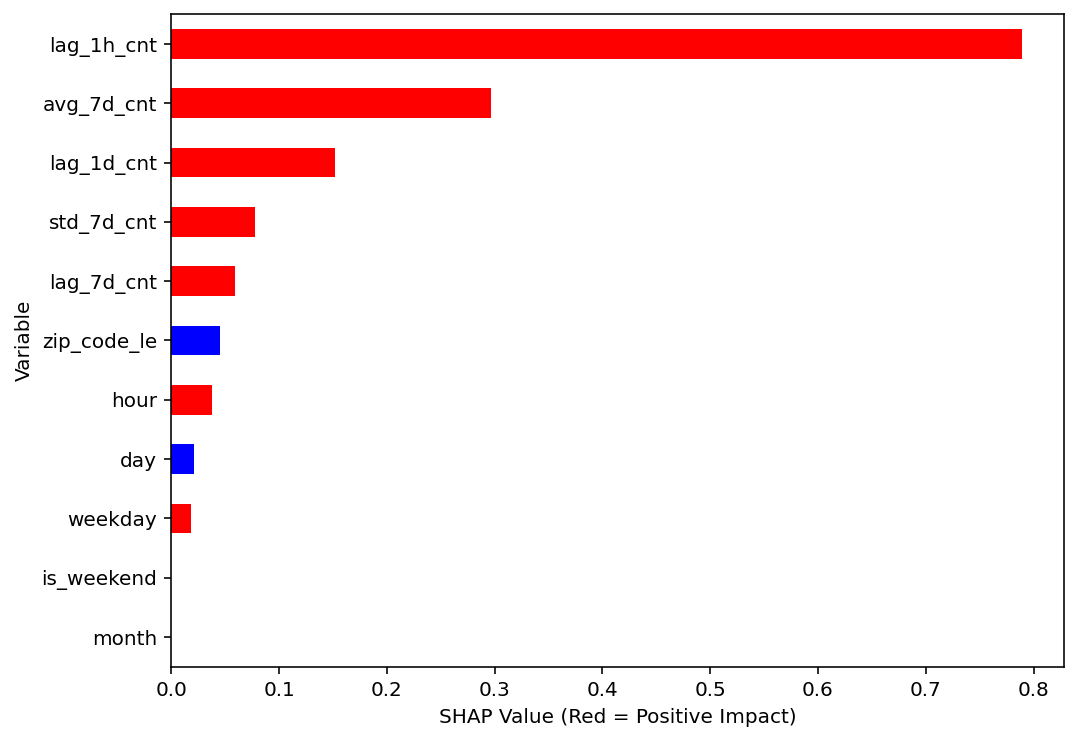

In [54]:
def ABS_SHAP(df_shap, df):
    shap_v = pd.DataFrame(df_shap)
    feature_list = df.columns
    shap_v.columns = feature_list
    df_v = df.copy().reset_index().drop('index',axis=1)
    
    corr_list = list()
    for i in feature_list:
        b = np.corrcoef(shap_v[i],df_v[i])[1][0]
        corr_list.append(b)
    corr_df = pd.concat([pd.Series(feature_list),pd.Series(corr_list)],axis=1).fillna(0)
    corr_df.columns  = ['Variable','Corr']
    corr_df['Sign'] = np.where(corr_df['Corr']>0,'red','blue')
    
    shap_abs = np.abs(shap_v)
    k=pd.DataFrame(shap_abs.mean()).reset_index()
    k.columns = ['Variable','SHAP_abs']
    k2 = k.merge(corr_df,left_on = 'Variable',right_on='Variable',how='inner')
    k2 = k2.sort_values(by='SHAP_abs',ascending = True)
    colorlist = k2['Sign']
    ax = k2.plot.barh(x='Variable',y='SHAP_abs',color = colorlist, figsize=(8,6),legend=False)
    ax.set_xlabel("SHAP Value (Red = Positive Impact)")
    
ABS_SHAP(shap_values, x_test)

- 과거 1시간전의 수요 Feature가 가장 많이 기여하며, 양의 경향성을 가지고 있는 것을 알 수 있다.
- 과거 7일전 수요, day에 대한 Feature는 기여도가 비교적 낮으며, 음의 경향성을 가지고 있는 것을 알 수 있다.

#### SHAP Summary Plot

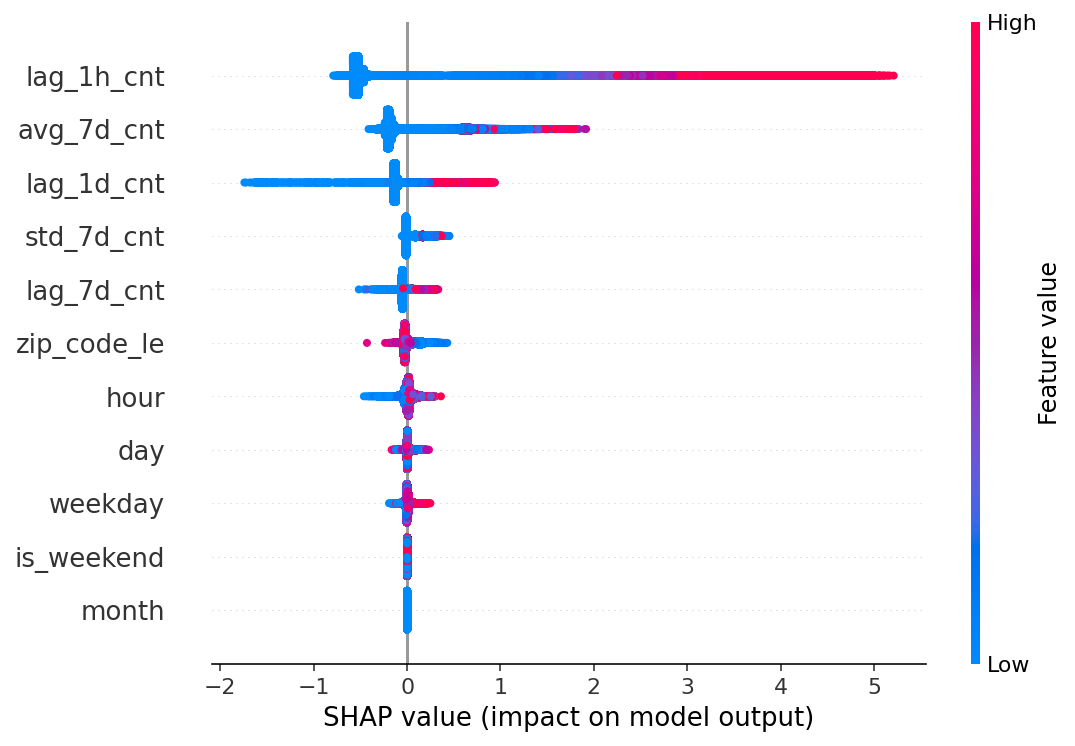

In [55]:
shap.summary_plot(shap_values, x_test)

- lag_1h_cnt : 값이 높을수록, 예상 수요가 높은 경향이 있다.
- avg_7d_cnt : 값이 높을수록, 예상 수요가 높은 경향이 있다.
- lag_1d_cnt : 값이 높을수록, 예상 수요가 높은 경향이 있다.
- zip_code_le : 값이 높을수록, 예상 수요가 낮은 경향이 있다.
- std_7d_cnt, day : Feature value에 따른 Shap value의 상관성이 모호해 해석해 모호성이 존재한다.

#### SHAP Dependence Plot
- 기여도가 높은 TOP3 Feature와 범주형변수인 zip_code_le 변수에 대한 분석

1. `lag_1h_cnt`에 대한 dependence plot
    - 0에 가까울 때, 예상 수요가 낮은 경향을 보인다.
    - 변수값이 증가할수록 예상 수요가 높은 경향을 보인다.
    - 해당 변수와 강한 상관성이 있는 변수는 `lag_1d_cnt`이며, 0 - 500 구간에서 `lag_1d_cnt`값이 높을 때 예상 수요에 대해 좀 더 높은 영향력을 갖는다는 것을 볼 수 있다.

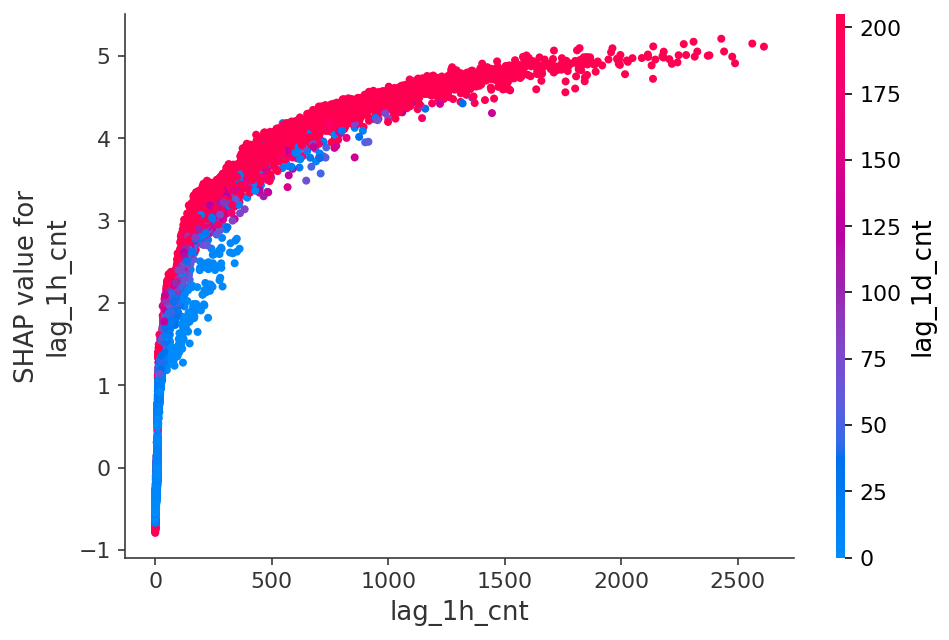

In [56]:
shap.dependence_plot('lag_1h_cnt', shap_values, x_test)

2. `avg_7d_cnt`에 대한 dependence plot
    - 0에 가까운 구간 외에 예상 수요가 높은 경향을 보인다.
    - 강한 상관성이 있는 변수는 `hour`이며, 0-200 구간에서 `hour`값이 높을 때 `avg_7d_cnt`변수가 Target변수에 대해 좀 더 영향력이 낮다고 할 수 있다.

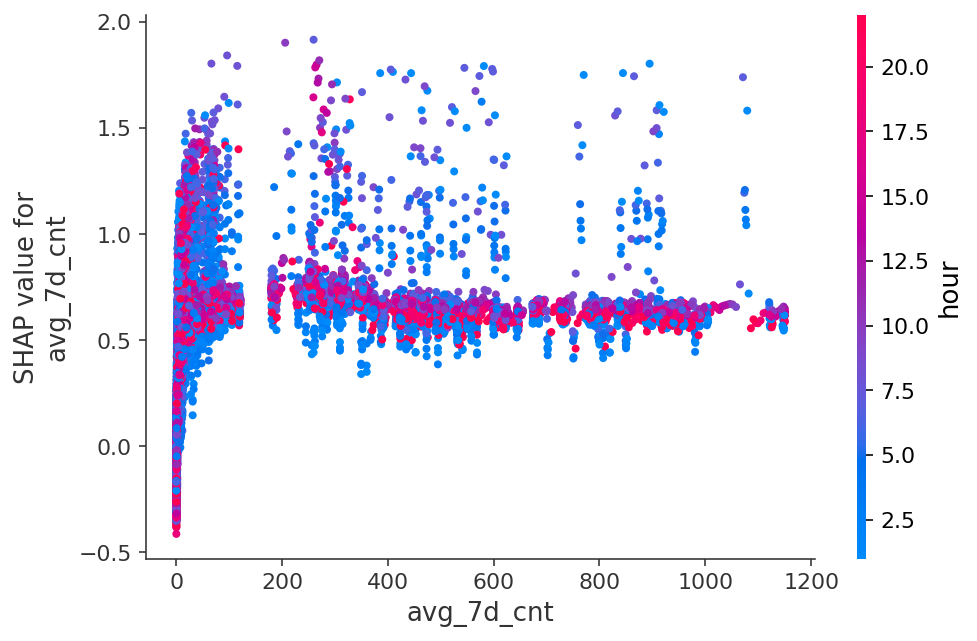

In [57]:
shap.dependence_plot('avg_7d_cnt', shap_values, x_test)

3. `lag_1d_cnt`에 대한 dependence plot
    - 0에 가까운 구간 외에 예상 수요가 증가하는 경향을 보인다.
    - 강한 상관성이 있는 변수는 `lag_1h_cnt`이며, `lag_1h_cnt`값이 높을 때 `lag_1d_cnt`변수가 Target변수에 대해 영향력이 낮다고 볼 수 있다.

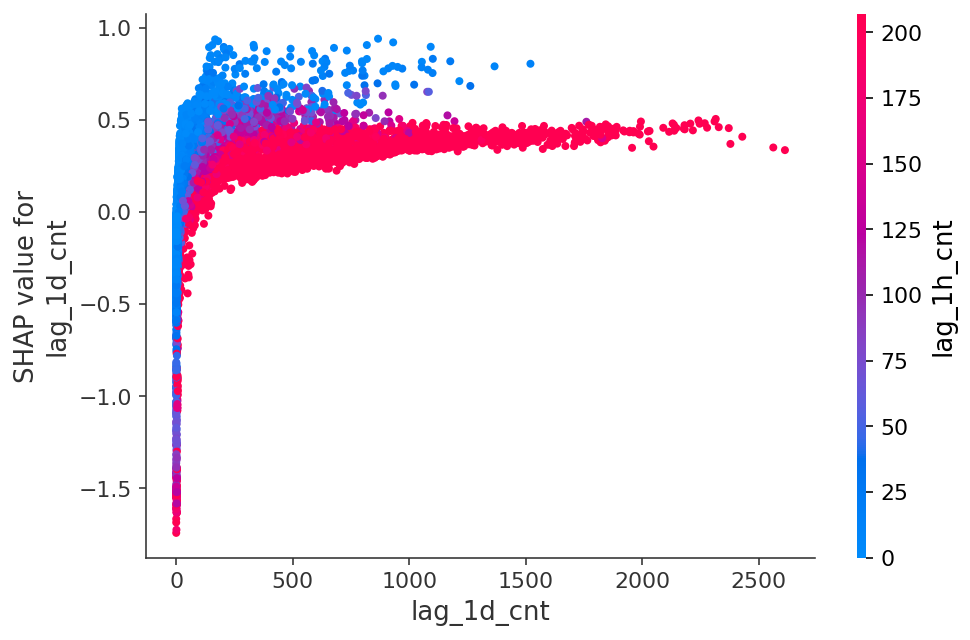

In [59]:
shap.dependence_plot('lag_1d_cnt', shap_values, x_test)

4. `zip_code_le`에 대한 dependence plot
    - 강한 상관성이 있는 변수는 `hour`이며, `hour`값이 높을 때 50근처에 있는 지역들은 Target변수에 대해 영향력이 크다고 볼 수 있다.

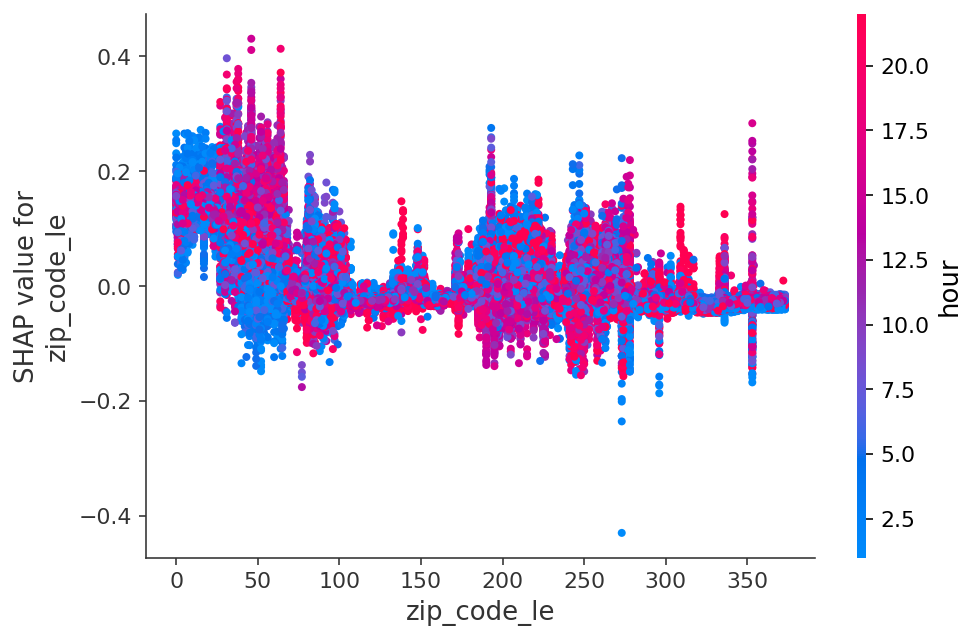

In [70]:
shap.dependence_plot('zip_code_le', shap_values, x_test)

---

### 실제값과 예측값간 비교를 통한 성능 평가
- 04_Notebook에서 Best Model의 성능 평가 결과와 비교했을 때, 전반적으로 실제값과 비슷하게 예측이 된다는 것을 알 수 있다.

In [78]:
plt.style.use('ggplot')

In [79]:
test_df['y_true'] = y_test_raw
test_df['y_pred'] = y_pred_reverse

test_df['year'] = 2015
test_df['datetime'] = pd.to_datetime(test_df[['year', 'month', 'day', 'hour']])

test_df['zip_code'] = le.inverse_transform(test_df['zip_code_le'])

test_df.tail(2)

,month,day,weekday,hour,is_weekend,lag_1h_cnt,lag_1d_cnt,lag_7d_cnt,avg_7d_cnt,std_7d_cnt,zip_code_le,y_true,y_pred,year,datetime,zip_code
278254,1,31,5,22,1,0.0,0.0,0.0,0.01,0.0,373,0,0.002021,2015,2015-01-31 22:00:00,14801
278255,1,31,5,23,1,0.0,0.0,0.0,0.01,0.0,373,0,-0.003183,2015,2015-01-31 23:00:00,14801


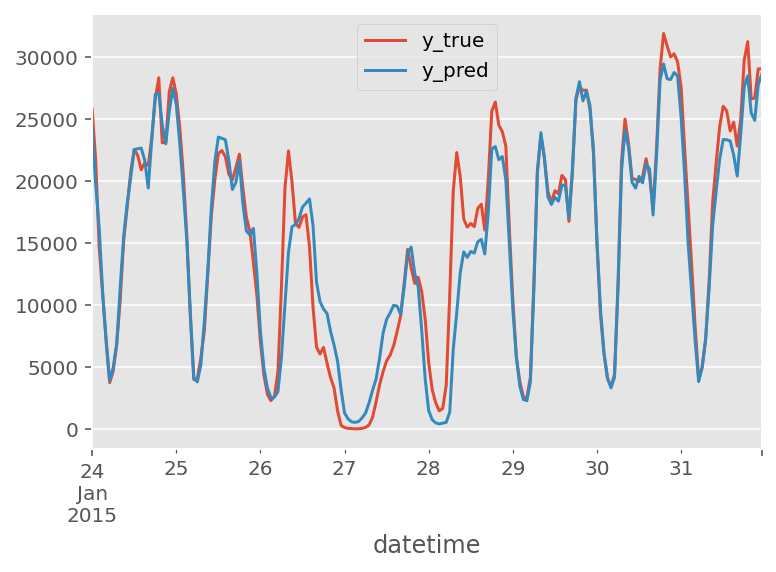

In [74]:
test_df.groupby('datetime').sum()[['y_true', 'y_pred']].plot();

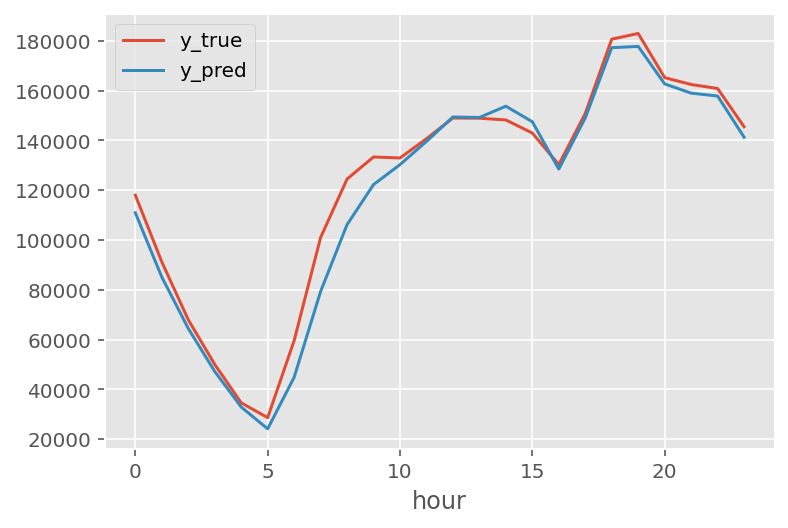

In [75]:
test_df[['hour','y_true', 'y_pred']].groupby('hour').sum()[['y_true', 'y_pred']].plot();

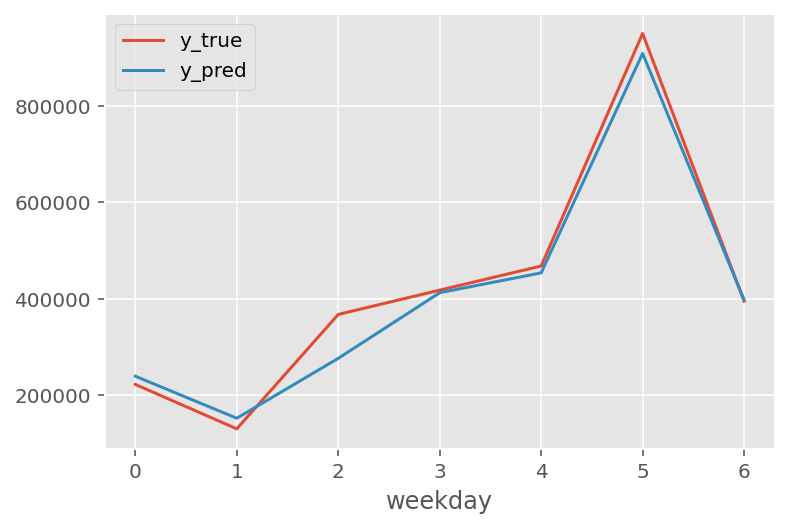

In [76]:
test_df[['weekday','y_true', 'y_pred']].groupby('weekday').sum()[['y_true', 'y_pred']].plot();

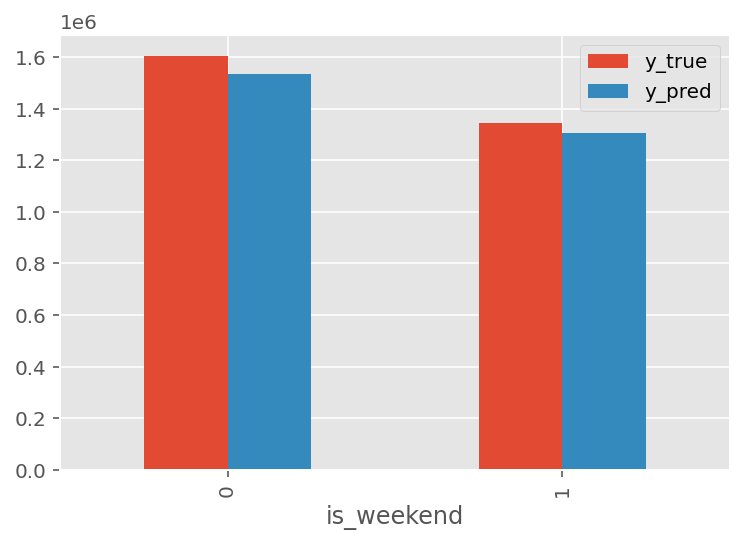

In [77]:
test_df[['is_weekend','y_true', 'y_pred']].groupby('is_weekend').sum()[['y_true', 'y_pred']].plot(kind='bar');

---

---

## Final Model 결과 분석 Result

### Feature Engineering
- 과거의 수요에 대한 count 및 평균 & 표준편차에 대한 데이터 추가

### Final Modeling
- log1p를 사용해 inf값이 생기지 않게 전처리 (inverse : expm1)
- 결측치를 backfill로 대체
- 04 Notebook의 Best Model과 동일한 모델 및 파라미터 적용

### 성능평가

#### 1. Metric score 비교
- 04_Notebook의 Best Model MSE : 12130
- Final Model MSE : 919

#### 2. Feature 분석
- Target변수에 대한 기여도 TOP3 및 범주형 변수 : `lag_1h_cnt` > `avg_7d_cnt` > `lag_1d_cnt` 이며, 모두 Target에 대해 양의 영향력을 주고, 범주형 변수인 `zip_code_le`는 Target에 대해 음의 영향력을 준다고 할 수 있다.
```
    - lag_1h_cnt : 상관성이 강한 변수는 lag_1d_cnt이며, [0, 500] 구간에서 lag_1d_cnt값이 높을 때 
                   Target에 대해 영향력이 크다고 할 수 있다.
    - avg_7d_cnt : 상관성이 강한 변수는 hour이며, [0, 200] 구간에서 hour값이 높을 때
                   Target에 대해 영향력이 낮다고 할 수 있다.
    - lag_1d_cnt : 상관성이 강한 변수는 lag_1h_cnt이며, lag_1h_cnt값이 높을 때
                   Target에 대해 영향력이 낮다고 할 수 있다.
    - zip_code_le : 상관성이 강한 변수는 hour이며, hour값이 높을 때
                    50근처에 있는 지역들은 Target에 대해 영향력이 크다고 할 수 있다.
```

- `std_7d_cnt`, `day` : 해당 변수들은 값에 따른 Shap value의 상관성이 모호해 해석의 모호성이 존재한다.

#### 3. 실제값과 예측값의 비교를 통한 분석
- 실제값과 예측값이 비슷한 분포를 보이는 것을 통해 특정 Event가 발생해도 예측성능이 좋다는 것을 알 수 있다.

### 제언
- datetime에 따른 수요 예측은 시계열 분석에 대한 방향성이 짙기 때문에 과거 수요 데이터를 반영하여 Ensemble 모델링을 했지만, 모든 월의 데이터와 LSTM 모델을 통해 딥러닝을 하는 것도 좋은 방법이라고 생각합니다. (향후 진행 예정)
- datetime에 대한 데이터를 제외하고 Target변수를 설명할 수 있는 다른 데이터가 존재했다면 좀 더 좋은 성능을 보였을 것으로 생각합니다.

### Google Composer - Airflow 진행방향
- Train, Predict에 대한 2개의 dags를 생성
- Bash Operator를 사용해 task를 구성하고, bash command로 실행시킬 main python file은 변수를 받아 환경을 설정할 수 있게 구성
- BigQuery를 사용한 데이터 Extract 및 Load를 위해 gcp connetion에 사용한 jwt 생성